# Fake news classification (RU)


In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)

## EDA

Посмотрим на данные, распределения, баланс классов

In [2]:
train_data = pd.read_csv('dataset/raw/train.tsv', sep='\t')
test_data = pd.read_csv('dataset/raw/test.tsv', sep='\t')

train_data.head()

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


In [3]:
train_data['is_fake'].value_counts()

1    2879
0    2879
Name: is_fake, dtype: int64

Датасет сбалансирован, это очень хорошо, учитвая то, что наша ключевая метрика - F1

<AxesSubplot:>

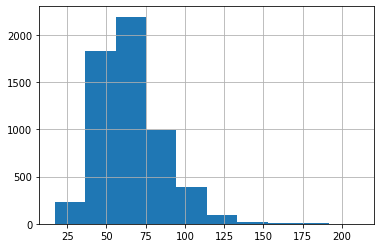

In [4]:
train_data['title'].str.len().hist()

Максимальная длина предложения нужна для некоторых моделей

In [5]:
MAX_SEQ_LENGTH = max(train_data['title'].str.len())
MAX_SEQ_LENGTH

211

## Data preprocessing


In [6]:
from sklearn.model_selection import train_test_split
import nltk

nltk.download('stopwords')

train_data = pd.read_csv('dataset/raw/train.tsv', sep='\t')
test_data = pd.read_csv('dataset/raw/test.tsv', sep='\t')

train_data.head()

[nltk_data] Downloading package stopwords to /home/danya-
[nltk_data]     sakharov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


In [7]:
! jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [8]:
from preprocess import get_lemmas_from_text

train_data['lemmas'] = get_lemmas_from_text(train_data['title'])
test_data['lemmas'] = get_lemmas_from_text(test_data['title'])
train_data.head()

  0%|          | 0/5758 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,title,is_fake,lemmas
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1,москвич владимир клутин приходить счет вмешате...
1,Агент Кокорина назвал езду по встречке житейск...,0,агент кокорин называть езда встречок житейский...
2,Госдума рассмотрит возможность введения секрет...,1,госдума рассматривать возможность введение сек...
3,ФАС заблокировала поставку скоростных трамваев...,0,фас заблокировать поставка скоростной трамвай ...
4,Против Навального завели дело о недоносительст...,1,против навальный заводить дело недоносительств...


Посмотрим теперь на лемматизированные тексты и самые частотные слова в них 

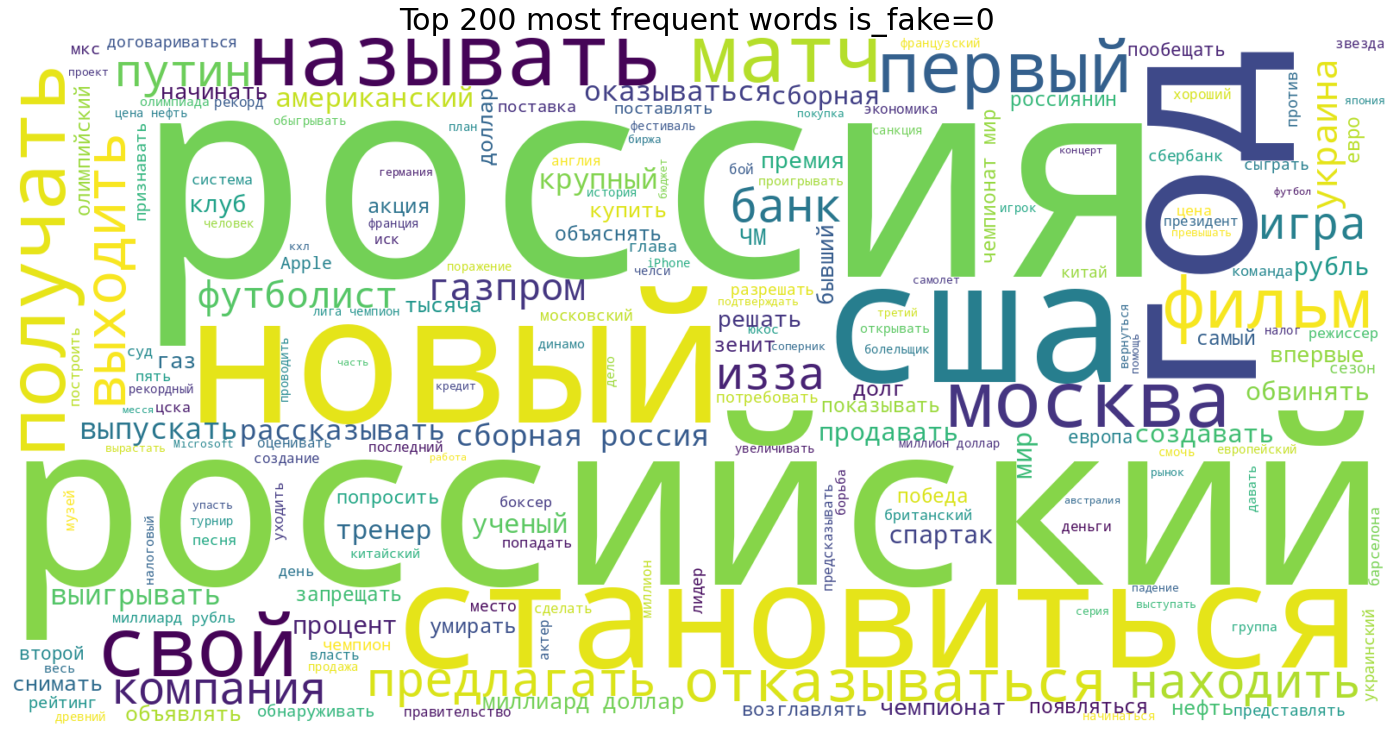

In [9]:
from visualize import get_wordcloud

get_wordcloud(train_data[train_data['is_fake']==0]['lemmas'], title='Top 200 most frequent words is_fake=0')

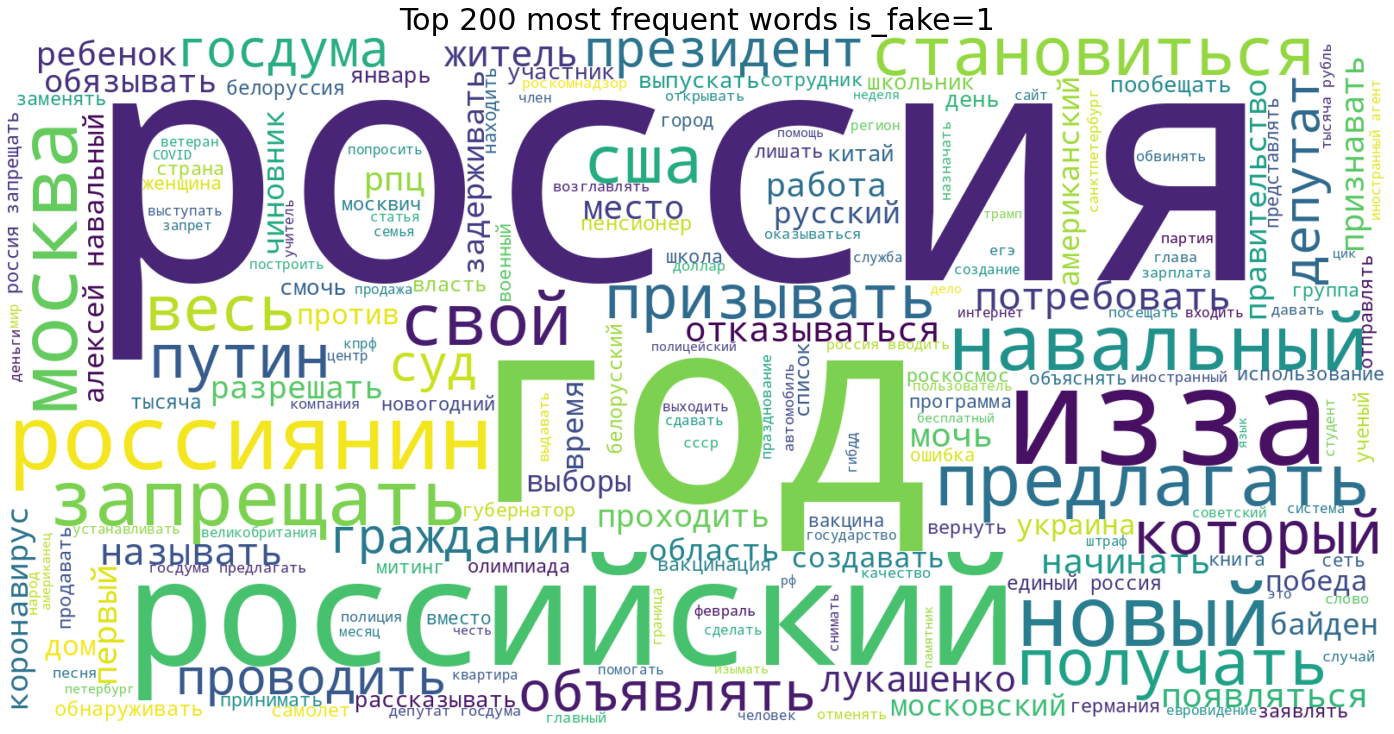

In [10]:
get_wordcloud(train_data[train_data['is_fake']==1]['lemmas'], title='Top 200 most frequent words is_fake=1')

К сожалению, самые частотные слова встречаются как в фейковых, так и настоящих новостях

Разобьем на train/val со стратификацией по таргету, чтобы поулчить сбалансированные классы

In [10]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train_data.drop('title',axis=1), test_size=0.2, random_state=42, stratify=train_data['is_fake'])

print("total train examples %s" % len(train))
print("total test examples %s\n" % len(val))
print(train['is_fake'].value_counts())

total train examples 4606
total test examples 1152

1    2303
0    2303
Name: is_fake, dtype: int64


In [11]:
import os

preprocessed_path = "dataset/preprocessed"

if not os.path.exists(preprocessed_path):
    os.makedirs(preprocessed_path)
    
train.to_csv(preprocessed_path + '/train.csv')
val.to_csv(preprocessed_path + '/val.csv')
test_data.to_csv(preprocessed_path + '/test.csv')

## Modelling

In [12]:
import torch
from sklearn.metrics import classification_report

task_type = "GPU" if torch.cuda.is_available() else "CPU"

### PAC

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier

tfidf = TfidfVectorizer()
vec_train = tfidf.fit_transform(train['lemmas'])
vec_val = tfidf.transform(val['lemmas'])

pac = PassiveAggressiveClassifier(C = 0.01)

pac.fit(vec_train, train['is_fake'])
val_pred = pac.predict(vec_val)


print(classification_report(val['is_fake'], val_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       576
           1       0.85      0.85      0.85       576

    accuracy                           0.85      1152
   macro avg       0.85      0.85      0.85      1152
weighted avg       0.85      0.85      0.85      1152



Неплохой результат для первой примененной модели, посмотрим на другие

### Fasttext baseline


In [12]:
import fasttext

In [13]:
#Write data to file for fasttext classifier 
fasttext_path = "dataset/fasttext"

if not os.path.exists(fasttext_path):
    os.makedirs(fasttext_path)

with open(fasttext_path + '/data.train.txt', 'w+') as outfile:
    for x, y in zip(train['lemmas'], train['is_fake']):
        outfile.write('__label__' + str(y) + ' ' + x + '\n')


with open(fasttext_path + '/test.txt', 'w+') as outfile:
    for x, y in zip(val['lemmas'], val['is_fake']):
        outfile.write('__label__' + str(y) + ' ' + x + '\n')

In [14]:
classifier = fasttext.train_supervised(fasttext_path + '/data.train.txt', lr=1.0, epoch=25, wordNgrams=3)
    
num, precision, recall = classifier.test(fasttext_path + '/test.txt')

print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print('Number of examples:', num)

Read 0M words
Number of words:  9437
Number of labels: 2


Precision: 0.86111
Recall: 0.86111
Number of examples: 1152


Progress: 100.0% words/sec/thread:  545183 lr:  0.000000 avg.loss:  0.027791 ETA:   0h 0m 0s


Тоже неплохой результат, слегка лучше **PAC**

### CatBoost

In [24]:
from catboost import Pool, CatBoostClassifier

train_pool = Pool(data=
    train.drop(['is_fake'], axis=1), 
    label=train['is_fake'],
    text_features = ['lemmas']
)

valid_pool = Pool(data=
    val.drop(['is_fake'], axis=1), 
    label=val['is_fake'],
    text_features=['lemmas']
)

model = CatBoostClassifier(verbose=500, use_best_model=True, task_type=task_type)
model.fit(train_pool, eval_set=valid_pool)

Learning rate set to 0.062538
0:	learn: 0.6590950	test: 0.6522286	best: 0.6522286 (0)	total: 23.9ms	remaining: 23.9s
500:	learn: 0.3251543	test: 0.3572292	best: 0.3559229 (260)	total: 21s	remaining: 20.9s
999:	learn: 0.2927684	test: 0.3609633	best: 0.3559229 (260)	total: 42.2s	remaining: 0us
bestTest = 0.3559229109
bestIteration = 260
Shrink model to first 261 iterations.


In [26]:
pred = model.predict(val.drop(['is_fake'], axis=1))
print(classification_report(val['is_fake'],pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       576
           1       0.86      0.83      0.85       576

    accuracy                           0.85      1152
   macro avg       0.85      0.85      0.85      1152
weighted avg       0.85      0.85      0.85      1152



**Catboost** в среднем показывает аналогичные результаты (из коробки)

### CatBoost + Optuna

Попробуем подобрать гиперпараметры с помощью **optuna**

In [27]:
import optuna
from utils import CB_objective
from functools import partial

In [28]:
optuna.logging.set_verbosity(0)
study = optuna.create_study(direction="maximize")
study.optimize(partial(CB_objective, task_type=task_type, train_pool=train_pool,
               valid_pool=valid_pool, val=val), n_trials=50, timeout=600, n_jobs=1)

In [17]:
study.best_params

{'depth': 13,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'learning_rate': 0.08,
 'l2_leaf_reg': 0.2494718345819619}

In [18]:
model = CatBoostClassifier(**study.best_params, use_best_model=True, verbose=500, task_type=task_type)
model.fit(train_pool, eval_set=valid_pool)
pred = model.predict(val.drop(['is_fake'], axis=1))
print(classification_report(val['is_fake'],pred))

0:	learn: 0.6407924	test: 0.6293740	best: 0.6293740 (0)	total: 327ms	remaining: 5m 26s
500:	learn: 0.1293011	test: 0.3517248	best: 0.3423119 (257)	total: 2m 31s	remaining: 2m 30s
999:	learn: 0.0575841	test: 0.3785409	best: 0.3423119 (257)	total: 5m 1s	remaining: 0us
bestTest = 0.3423119121
bestIteration = 257
Shrink model to first 258 iterations.
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       576
           1       0.89      0.85      0.87       576

    accuracy                           0.87      1152
   macro avg       0.87      0.87      0.87      1152
weighted avg       0.87      0.87      0.87      1152



Отличный результат, побили предыдущие модели

### RuBERT


Попробуем предобученный RuBERT с DeepPavlov

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
from transformers import AutoTokenizer

TOKENIZER_NAME = "DeepPavlov/rubert-base-cased"
MODEL_NAME = "DeepPavlov/rubert-base-cased"
SAVED_MODEL_NAME = MODEL_NAME.split("/", 1)[1]
BATCH_SIZE = 16

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)

Подготавливаем данные 

In [52]:
from preprocess import convert_examples_to_inputs
from preprocess import get_data_loader

train_features = convert_examples_to_inputs(
    train['lemmas'], train['is_fake'], MAX_SEQ_LENGTH, tokenizer)
val_features = convert_examples_to_inputs(
    val['lemmas'], val['is_fake'], MAX_SEQ_LENGTH, tokenizer)

train_dataloader = get_data_loader(train_features, BATCH_SIZE, shuffle=True)
val_dataloader = get_data_loader(val_features, BATCH_SIZE, shuffle=False)

Сделаем trasnfer learning, заменив слой классификатора на новый и дообучим модель

In [15]:
from transformers.models.bert.modeling_bert import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(MODEL_NAME)
out_features = model.bert.encoder.layer[1].output.dense.out_features
model.classifier = torch.nn.Linear(out_features, 2)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

In [16]:
from transformers.optimization import get_linear_schedule_with_warmup
from torch.optim import AdamW

GRADIENT_ACCUMULATION_STEPS = 1
NUM_TRAIN_EPOCHS = 10
LEARNING_RATE = 1e-5
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5
PATIENCE = 4
OUTPUT_DIR = "trained_models/"


model.to(device)

num_train_steps = int(len(train_dataloader.dataset) /
                      BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
                      
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())

no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(
        nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(
        nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)

loss_fn = torch.nn.CrossEntropyLoss()

In [17]:
from model import train_model

config = (int(NUM_TRAIN_EPOCHS), GRADIENT_ACCUMULATION_STEPS, MAX_GRAD_NORM, SAVED_MODEL_NAME)
train_model(device, model, train_dataloader, val_dataloader, loss_fn, optimizer, scheduler, config)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.013278788886964321
Dev accuracy: 0.8490028490028491
New record, model saved to trained_models/rubert-base-cased


Epoch:  10%|█         | 1/10 [01:46<15:54, 106.09s/it]

Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Loss history: [0.013278788886964321]
Dev loss: 0.009276323020458221
Dev accuracy: 0.8954970263381479
New record, model saved to trained_models/rubert-base-cased


Epoch:  20%|██        | 2/10 [03:33<14:13, 106.75s/it]

Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Loss history: [0.013278788886964321, 0.009276323020458221]
Dev loss: 0.013799780048429966
Dev accuracy: 0.9049235993208828
New record, model saved to trained_models/rubert-base-cased


Epoch:  30%|███       | 3/10 [05:20<12:29, 107.06s/it]

Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch:  40%|████      | 4/10 [07:07<10:40, 106.80s/it]

Loss history: [0.013278788886964321, 0.009276323020458221, 0.013799780048429966]
Dev loss: 0.023378873243927956
Dev accuracy: 0.9011576135351737


Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch:  50%|█████     | 5/10 [08:53<08:53, 106.65s/it]

Loss history: [0.009276323020458221, 0.013799780048429966, 0.023378873243927956]
Dev loss: 0.02291104942560196
Dev accuracy: 0.9047619047619047


Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Loss history: [0.013799780048429966, 0.023378873243927956, 0.02291104942560196]
Dev loss: 0.027486750856041908
Dev accuracy: 0.9138381201044387
New record, model saved to trained_models/rubert-base-cased


Epoch:  60%|██████    | 6/10 [10:41<07:07, 106.96s/it]

Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch:  70%|███████   | 7/10 [12:27<05:20, 106.82s/it]

Loss history: [0.023378873243927956, 0.02291104942560196, 0.027486750856041908]
Dev loss: 0.03339913859963417
Dev accuracy: 0.912739965095986


Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch:  80%|████████  | 8/10 [14:14<03:33, 106.73s/it]

Loss history: [0.02291104942560196, 0.027486750856041908, 0.03339913859963417]
Dev loss: 0.027745062485337257
Dev accuracy: 0.8992805755395685


Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Loss history: [0.027486750856041908, 0.03339913859963417, 0.027745062485337257]
Dev loss: 0.03383451700210571
Dev accuracy: 0.9147826086956522
New record, model saved to trained_models/rubert-base-cased


Epoch:  90%|█████████ | 9/10 [16:01<01:47, 107.01s/it]

Training iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 100%|██████████| 10/10 [17:48<00:00, 106.83s/it]

Loss history: [0.03339913859963417, 0.027745062485337257, 0.03383451700210571]
Dev loss: 0.031597185879945755
Dev accuracy: 0.9055258467023173


In [53]:
from utils import val_report

model = BertForSequenceClassification.from_pretrained(os.path.join(OUTPUT_DIR, SAVED_MODEL_NAME))

dev_correct, dev_predicted = val_report(device, model, train_dataloader, val_dataloader, loss_fn)

Evaluation iteration:   0%|          | 0/288 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/72 [00:00<?, ?it/s]

Training performance: (0.9997828918801563, 0.9997828918801563, 0.9997828918801563, None)
Development performance: (0.9149305555555556, 0.9149305555555556, 0.9149305555555556, None)
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       576
           1       0.92      0.91      0.91       576

    accuracy                           0.91      1152
   macro avg       0.91      0.91      0.91      1152
weighted avg       0.91      0.91      0.91      1152



Метрики сильно выросли, финальный предикт будем делать этой моделью (**rubert-base-cased**). Интересно, что одной моделью удалось достичь подобного качества, т.к. задача кажется не настолько лингвистически обусловленной. Иными словами, лингвистически сложно определить является ли новость фейком или нет - это просто две новости, причем с общей "новостной" лексикой.  Если бы можно было использовать внешние данные, например, название ресурса откуда взята новость или имея базу размеченных и кластеризованных по фейк/не фейк критерию новостей, модель получилась бы интерпретируемой и точной.

Также, у меня была идея попробовать **Siamese BERT**, чтобы обучить модель энкодить *фейк*-*фейк* и *не_фейк*-*не_фейк* пары близко друг к другу, а *фейк*-*не_фейк* далеко в признаковом пространстве. Кажется, что такой подход вкупе с сбалансированным датасетом может дать хороший резульат, благодаря качественному энкодингу. К сожалению, времени на реализацию не хватило. В дальнейшем исследовании можно было бы посмотреть различные pair-wise метрики для обучения BERT на парах предложений

## Test inference (BERT)

In [55]:
from model import evaluate

test_features = convert_examples_to_inputs(test_data['lemmas'], test_data['is_fake'], MAX_SEQ_LENGTH, tokenizer)
test_dataloader = get_data_loader(test_features, BATCH_SIZE, shuffle=False)

_, _, predicted_labels = evaluate(device, model, test_dataloader, loss_fn)

Evaluation iteration:   0%|          | 0/63 [00:00<?, ?it/s]

In [56]:
from pathlib import Path

path = Path('../prediction.tsv').resolve()
prediction = pd.DataFrame({'title':test_data['title'], 'is_fake':pd.Series(predicted_labels)})
prediction.to_csv(path, sep='\t', index=False)